# Análisis del Modelo de Predicción de Dengue

Este notebook contiene un análisis completo del modelo BiLSTM para predicción de casos de dengue.

## 1. Configuración e Importación de Librerías

In [109]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr, norm
import joblib
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Importaciones opcionales para análisis avanzado
try:
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.graphics.tsaplots import plot_acf
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("⚠️ statsmodels no está instalado. Algunos análisis avanzados no estarán disponibles.")
    print("   Instala con: pip install statsmodels")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


## 2. Cargar Modelo y Componentes

In [110]:

MODEL_DIR = "models"
MODEL_PATH = f"{MODEL_DIR}/bilstm_model.h5"
SCALER_PATH = f"{MODEL_DIR}/scaler.pkl"

# Cargar modelo
print("📦 Cargando modelo...")
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])
print(f"✅ Modelo cargado: {model.input_shape} -> {model.output_shape}")

# Cargar scaler
print("📦 Cargando scaler...")
scaler = joblib.load(SCALER_PATH)
print("✅ Scaler cargado")

# Información del modelo
print(f"\n📊 Arquitectura del modelo:")
model.summary()


📦 Cargando modelo...
✅ Modelo cargado: (None, 8, 4) -> (None, 1)
📦 Cargando scaler...
✅ Scaler cargado

📊 Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,489 (154.25 KB)

 Trainable params: 39,489 (154.25 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Cargar Dataset Original y Definir Llaves

*Importante: Carga el mismo CSV que usaste para entrenar el modelo*

In [111]:

# Cargar datos del CSV original usado para entrenar
# IMPORTANTE: Usa el mismo CSV que usaste para entrenar el modelo
# Ejemplo: df_model = pd.read_csv("dengue_clima_limpio_2000_2020.csv", parse_dates=["fecha"])

# Si no tienes el CSV, descomenta y ajusta la ruta:
# df_model = pd.read_csv("ruta/a/tu/archivo.csv", parse_dates=["fecha"])

# Para este ejemplo, intentaremos cargar el CSV original
try:
    df_model = pd.read_csv("dengue_clima_limpio_2000_2020.csv", parse_dates=["fecha"])
    print("✅ CSV original cargado: dengue_clima_limpio_2000_2020.csv")
except FileNotFoundError:
    print("⚠️ ADVERTENCIA: No se encontró el CSV original")
    print("⚠️ REEMPLAZA este código con la carga de tus datos reales del CSV de entrenamiento")
    print("⚠️ El modelo fue entrenado con datos agrupados por distrito, usa el mismo proceso")
    
    # Generar datos sintéticos de ejemplo (SOLO PARA DEMOSTRACIÓN)
    dates = pd.date_range(start='2000-01-01', end='2020-12-31', freq='W')
    np.random.seed(42)
    df_model = pd.DataFrame({
        'fecha': dates,
        'departamento': ['LIMA'] * len(dates),
        'provincia': ['LIMA'] * len(dates),
        'distrito': ['LIMA'] * len(dates),
        'casos': np.random.poisson(10, len(dates)),
        'precipitacion_mm': np.random.gamma(2, 10, len(dates)),
        'tmin': 18 + np.random.normal(0, 3, len(dates)),
        'tmax': 28 + np.random.normal(0, 4, len(dates))
    })
    print("⚠️ Usando datos sintéticos para demostración")

# Fecha como índice y orden temporal
df_model = df_model.set_index("fecha").sort_index()

# Llaves espaciales (para agrupar por distrito)
group_keys = ["departamento", "provincia", "distrito"]

print(f"✅ Datos cargados: {df_model.shape}")
print(f"   Columnas: {list(df_model.columns)}")
df_model.head()


✅ CSV original cargado: dengue_clima_limpio_2000_2020.csv
✅ Datos cargados: (41828, 9)
   Columnas: ['departamento', 'provincia', 'distrito', 'casos', 'latitud', 'longitud', 'precipitacion_mm', 'tmin', 'tmax']


,departamento,provincia,distrito,casos,latitud,longitud,precipitacion_mm,tmin,tmax
fecha,,,,,,,,,
2000-01-03,LORETO,ALTO AMAZONAS,YURIMAGUAS,3.0,-5.8842,-76.1281,6.337421,21.774286,31.864286
2000-01-03,LORETO,MAYNAS,IQUITOS,7.0,-3.7481,-73.2442,0.253934,21.728573,34.418570
2000-01-03,PIURA,MORROPON,CHULUCANAS,1.0,-5.0972,-80.1603,0.063078,18.714285,33.717144
2000-01-03,SAN MARTIN,MARISCAL CACERES,JUANJUI,1.0,-7.1767,-76.7239,4.192993,21.362858,32.801430
2000-01-03,TUMBES,TUMBES,CORRALES,2.0,-3.6014,-80.4806,0.030539,20.202856,31.158571


## 4. Crear Secuencias Agrupadas por Distrito

In [112]:

WINDOW_SIZE = 8     # semanas de historial
HORIZON = 1         # predecimos 1 semana adelante

# Variables de entrada (incluyo casos pasados como feature)
feature_cols = ["casos", "precipitacion_mm", "tmin", "tmax"]
FEATURES = feature_cols  # Para compatibilidad con código posterior

# Asegurar orden por llaves + fecha
df_seq = df_model.sort_values(group_keys + [df_model.index.name])

def make_sequences(df_grouped, window_size, horizon):
    """
    Crea ventanas deslizantes por distrito.
    Para cada distrito:
      X: [window_size, n_features]
      y: [horizon] (casos futuros)
    Devuelve:
      X: np.array [N_samples, window_size, n_features]
      y: np.array [N_samples, horizon]
      dates_arr: fecha del target (último paso del horizonte)
      keys_arr: llave (departamento, provincia, distrito) de cada muestra
    """
    X_list, y_list = [], []
    dates_list, keys_list = [], []

    for keys, g in df_grouped:
        g = g.sort_index()
        values = g[feature_cols].values
        target = g["casos"].values
        dates = g.index.values  # fechas

        n = len(g)
        max_i = n - window_size - horizon + 1
        if max_i <= 0:
            continue  # serie demasiado corta

        for i in range(max_i):
            x = values[i : i + window_size]
            y = target[i + window_size : i + window_size + horizon]

            X_list.append(x)
            y_list.append(y)
            dates_list.append(dates[i + window_size + horizon - 1])
            keys_list.append(keys)

    X = np.stack(X_list)
    y = np.stack(y_list).astype("float32")
    dates_arr = np.array(dates_list)
    keys_arr = np.array(keys_list, dtype=object)

    return X, y, dates_arr, keys_arr

# Crear secuencias agrupadas por distrito
X, y, seq_dates, seq_keys = make_sequences(
    df_seq.groupby(group_keys),
    window_size=WINDOW_SIZE,
    horizon=HORIZON,
)

print(f"✅ Secuencias creadas: {X.shape}")
print(f"   Total muestras: {len(X)}")
print(f"   Ventana: {WINDOW_SIZE} semanas")
print(f"   Features: {len(feature_cols)}")


✅ Secuencias creadas: (38433, 8, 4)
   Total muestras: 38433
   Ventana: 8 semanas
   Features: 4


## 5. Split Temporal 80/20 (Train/Test)

In [113]:

# Split 80% / 20% SIN mezclar tiempos
# - Ordenamos todas las secuencias por fecha de target
# - Primer 80% -> entrenamiento (usado para entrenar el modelo)
# - Último 20% -> test (usado para evaluación)

# Convertir fechas a tipo datetime64 si aún no lo están
seq_dates = seq_dates.astype("datetime64[D]")

# Orden global por fecha del target
order = np.argsort(seq_dates)
X_ord = X[order]
y_ord = y[order]
dates_ord = seq_dates[order]
keys_ord = seq_keys[order]

# Índice de corte 80/20
cut = int(0.8 * len(dates_ord))

X_train, X_test = X_ord[:cut], X_ord[cut:]
y_train, y_test = y_ord[:cut], y_ord[cut:]
dates_train, dates_test = dates_ord[:cut], dates_ord[cut:]
keys_train, keys_test = keys_ord[:cut], keys_ord[cut:]

print("Total muestras:", len(dates_ord))
print("Train (80%):", X_train.shape, y_train.shape, "hasta", dates_train[-1])
print("Test  (20%):", X_test.shape,  y_test.shape,  "desde", dates_test[0])

# Usar el conjunto de TEST para evaluación (último 20%)
X_val = X_test
y_val = y_test
dates_val = dates_test
keys_val = keys_test


Total muestras: 38433
Train (80%): (30746, 8, 4) (30746, 1) hasta 2017-12-25
Test  (20%): (7687, 8, 4) (7687, 1) desde 2017-12-25


## 6. Escalar Datos de Test

In [114]:

# Escalar usando el scaler guardado (entrenado con datos de train)
# El scaler fue entrenado SOLO con X_train, ahora lo aplicamos a X_test
X_val_scaled = scaler.transform(X_val.reshape(-1, len(feature_cols))).reshape(X_val.shape)

print(f"✅ Datos escalados: {X_val_scaled.shape}")
print(f"   Usando scaler entrenado con datos de entrenamiento")


✅ Datos escalados: (7687, 8, 4)
   Usando scaler entrenado con datos de entrenamiento


## 7. Generar Predicciones

In [115]:

print("🔮 Generando predicciones...")
y_pred = model.predict(X_val_scaled, verbose=0).ravel()

print(f"✅ Predicciones generadas: {len(y_pred)}")
print(f"   Rango real: [{y_val.min():.2f}, {y_val.max():.2f}]")
print(f"   Rango predicho: [{y_pred.min():.2f}, {y_pred.max():.2f}]")


🔮 Generando predicciones...
✅ Predicciones generadas: 7687
   Rango real: [1.00, 442.00]
   Rango predicho: [1.03, 407.30]


## 8. Métricas de Evaluación

In [116]:

# Asegurar que y_val y y_pred tengan la misma longitud
y_val = np.asarray(y_val).ravel()
y_pred = np.asarray(y_pred).ravel()

# Ajustar longitudes si son diferentes
min_len = min(len(y_val), len(y_pred))
if len(y_val) != len(y_pred):
    print(f"⚠️ ADVERTENCIA: Longitudes diferentes - y_val: {len(y_val)}, y_pred: {len(y_pred)}")
    print(f"   Usando los primeros {min_len} valores de ambos")
    y_val = y_val[:min_len]
    y_pred = y_pred[:min_len]

# Calcular métricas básicas
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

# Métricas adicionales
errors = y_val - y_pred
bias = np.mean(errors)
medae = median_absolute_error(y_val, y_pred)

# NRMSE (normalizado por rango y por media)
range_y = y_val.max() - y_val.min()
mean_y = y_val.mean()
nrmse_range = (rmse / (range_y + 1e-8)) * 100.0 if range_y > 0 else 0
nrmse_mean = (rmse / (mean_y + 1e-8)) * 100.0 if mean_y > 0 else 0

# sMAPE (Symmetric MAPE)
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2.0 + 1e-8
    return np.mean(num / den) * 100.0

smape_val = smape(y_val, y_pred)

# MASE (Mean Absolute Scaled Error) - comparado con naive estacional
def mase(y_true, y_pred, m=52):
    '''MASE usando naive estacional con periodo m (52 semanas ~ 1 año)'''
    y = np.asarray(y_true)
    if len(y) <= m:
        return np.nan
    scale = np.mean(np.abs(y[m:] - y[:-m]))
    return np.mean(np.abs(y_true - y_pred)) / (scale + 1e-8)

mase_val = mase(y_val, y_pred, m=52)

# Correlaciones (con validación adicional)
try:
    if len(y_val) >= 2 and len(y_pred) >= 2 and len(y_val) == len(y_pred):
        pearson_r, pearson_p = pearsonr(y_val, y_pred)
        spearman_rho, spearman_p = spearmanr(y_val, y_pred)
    else:
        print("⚠️ No se pueden calcular correlaciones: longitudes insuficientes o diferentes")
        pearson_r, pearson_p = np.nan, np.nan
        spearman_rho, spearman_p = np.nan, np.nan
except Exception as e:
    print(f"⚠️ Error calculando correlaciones: {e}")
    pearson_r, pearson_p = np.nan, np.nan
    spearman_rho, spearman_p = np.nan, np.nan

# Crear DataFrame con métricas
metrics_df = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE (%)', 'sMAPE (%)', 'MASE', 
                'Bias', 'MedAE', 'NRMSE (rango %)', 'NRMSE (media %)',
                'Pearson r', 'Spearman ρ'],
    'Valor': [mae, mse, rmse, r2, mape*100, smape_val, mase_val,
              bias, medae, nrmse_range, nrmse_mean,
              pearson_r, spearman_rho]
})

print("📊 MÉTRICAS DE EVALUACIÓN COMPLETAS")
print("=" * 60)
for _, row in metrics_df.iterrows():
    print(f"{row['Métrica']:20s}: {row['Valor']:12.4f}")

print(f"\n📈 Correlaciones:")
print(f"   Pearson r:   {pearson_r:.4f}  (p={pearson_p:.3e})")
print(f"   Spearman ρ: {spearman_rho:.4f}  (p={spearman_p:.3e})")

metrics_df


📊 MÉTRICAS DE EVALUACIÓN COMPLETAS
MAE                 :       3.6613
MSE                 :      66.9268
RMSE                :       8.1809
R²                  :       0.8542
MAPE (%)            :      78.3966
sMAPE (%)           :      56.3447
MASE                :       0.3079
Bias                :       0.5076
MedAE               :       1.3457
NRMSE (rango %)     :       1.8551
NRMSE (media %)     :      95.0980
Pearson r           :       0.9248
Spearman ρ          :       0.6730

📈 Correlaciones:
   Pearson r:   0.9248  (p=0.000e+00)
   Spearman ρ: 0.6730  (p=0.000e+00)


,Métrica,Valor
0,MAE,3.661258
1,MSE,66.926773
2,RMSE,8.180879
3,R²,0.854219
4,MAPE (%),78.396577
5,sMAPE (%),56.344681
6,MASE,0.307904
7,Bias,0.507569
8,MedAE,1.345744
9,NRMSE (rango %),1.855074


## 8.1 Comparación con Modelo Naive

In [117]:

# Asegurar que y_val y y_pred tengan la misma longitud (ya ajustados arriba)
# Comparación con modelo Naive (Random Walk)
# Naive: predice el mismo valor que la semana anterior
y_naive = np.roll(y_val, 1)
y_naive[0] = y_val[0]  # Primera muestra sin anterior

# Calcular métricas del naive
mae_naive = mean_absolute_error(y_val, y_naive)
rmse_naive = np.sqrt(mean_squared_error(y_val, y_naive))
r2_naive = r2_score(y_val, y_naive)
mape_naive = mean_absolute_percentage_error(y_val, y_naive)

# Diebold-Mariano test para comparar modelos
def diebold_mariano_test(y_true, y_pred1, y_pred0, h=1):
    '''Test de Diebold-Mariano comparando modelo 1 vs modelo 0 (baseline)'''
    y_true = np.asarray(y_true).reshape(-1)
    y_pred1 = np.asarray(y_pred1).reshape(-1)
    y_pred0 = np.asarray(y_pred0).reshape(-1)
    
    # Diferencia de pérdidas (squared error)
    e1 = y_true - y_pred1
    e0 = y_true - y_pred0
    d = e1**2 - e0**2
    
    T = len(d)
    d_bar = d.mean()
    
    # Autocovarianzas hasta lag h-1 (Newey–West)
    gamma = []
    for k in range(h):
        if k == 0:
            gamma_k = np.sum((d - d_bar) * (d - d_bar)) / T
        else:
            gamma_k = np.sum((d[k:] - d_bar) * (d[:-k] - d_bar)) / T
        gamma.append(gamma_k)
    
    var_d = gamma[0] + 2 * np.sum(gamma[1:])
    dm_stat = d_bar / np.sqrt(var_d / T + 1e-8)
    
    p_value = 2 * (1 - norm.cdf(np.abs(dm_stat)))
    return p_value

dm_p = diebold_mariano_test(y_val, y_pred, y_naive, h=1)

# Crear tabla comparativa
comparison_df = pd.DataFrame({
    'Modelo': ['Naive (RW)', 'BiLSTM'],
    'MAE': [mae_naive, mae],
    'RMSE': [rmse_naive, rmse],
    'R²': [r2_naive, r2],
    'MAPE (%)': [mape_naive*100, mape*100]
})

print("\n📊 COMPARACIÓN CON MODELO NAIVE (Random Walk)")
print("=" * 60)
print(comparison_df.to_string(index=False))
print(f"\n🔬 Test de Diebold-Mariano (BiLSTM vs Naive):")
print(f"   p-value: {dm_p:.4f}")
if dm_p < 0.05:
    print("   ✅ El modelo BiLSTM es significativamente mejor (p < 0.05)")
else:
    print("   ⚠️ No hay diferencia significativa (p >= 0.05)")

comparison_df



📊 COMPARACIÓN CON MODELO NAIVE (Random Walk)
    Modelo       MAE      RMSE        R²   MAPE (%)
Naive (RW) 11.989723 29.833982 -0.938751 370.581675
    BiLSTM  3.661258  8.180879  0.854219  78.396577

🔬 Test de Diebold-Mariano (BiLSTM vs Naive):
   p-value: 0.0000
   ✅ El modelo BiLSTM es significativamente mejor (p < 0.05)


,Modelo,MAE,RMSE,R²,MAPE (%)
0,Naive (RW),11.989723,29.833982,-0.938751,370.581675
1,BiLSTM,3.661258,8.180879,0.854219,78.396577


## 8.2 Análisis de Calidad del Modelo

📊 ANÁLISIS DE CALIDAD DEL MODELO

1️⃣ TEST DE NORMALIDAD DE RESIDUOS
----------------------------------------------------------------------

   D'Agostino-Pearson Test:
   • Estadístico: 3782.3159
   • p-value: 0.0000e+00
   ⚠️ Los residuos NO siguen una distribución normal (p <= 0.05)

2️⃣ ANÁLISIS DE ESTABILIDAD TEMPORAL
----------------------------------------------------------------------
   MAE por Período Temporal:
   • Inicial: 1.7674
   • Medio: 2.9342
   • Final: 4.6242
   ⚠️ Modelo moderadamente estable (CV = 0.462)

3️⃣ PERFORMANCE POR RANGOS DE VALORES
----------------------------------------------------------------------
   MAE por Rango de Valores Reales:
   • Bajo: 3.4527
   • Medio: 48.5135
   • Alto: 44.7741
   ⚠️ El modelo tiene performance variable según el rango de valores

4️⃣ ANÁLISIS DE VARIANZA DE RESIDUOS
----------------------------------------------------------------------
   • Varianza de residuos: 66.6692
   • Media de |residuos|: 3.6613
   • Coeficiente de

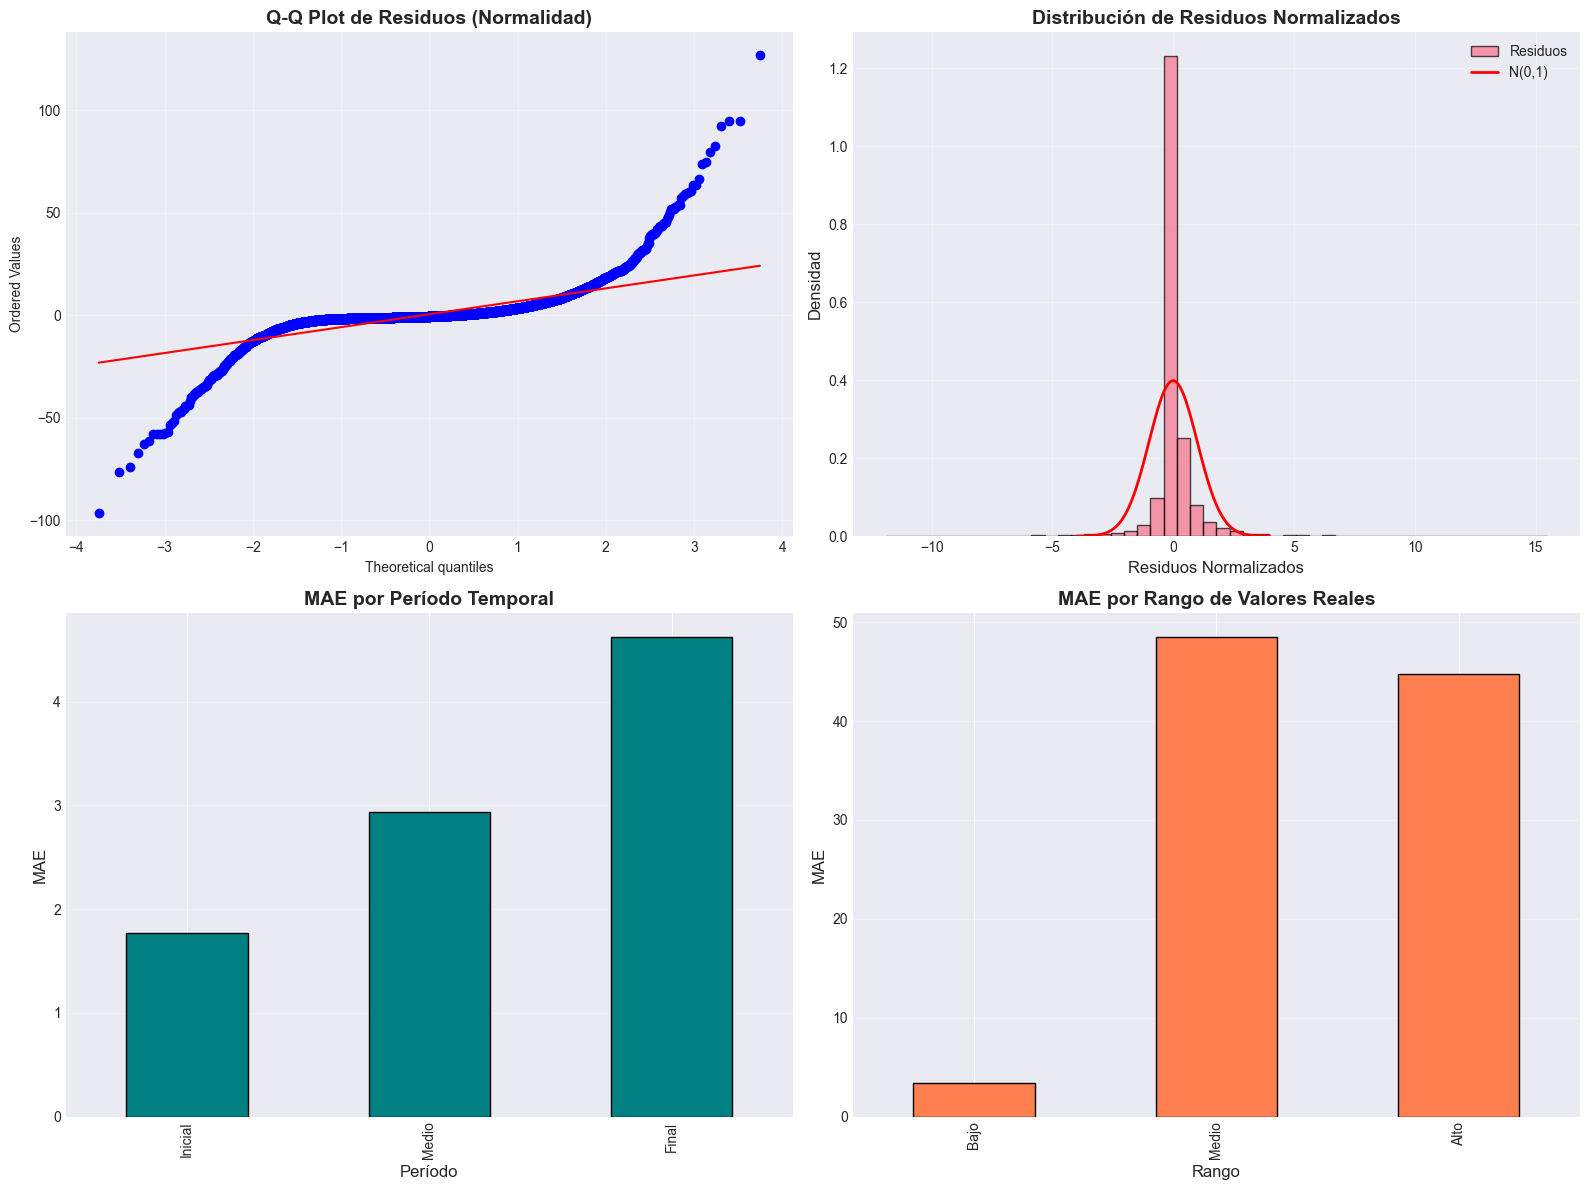


✅ Análisis de calidad completado


In [118]:

# Análisis de Calidad del Modelo
from scipy.stats import shapiro, normaltest

resid = y_val - y_pred
resid_normalized = (resid - resid.mean()) / (resid.std() + 1e-8)

print("=" * 70)
print("📊 ANÁLISIS DE CALIDAD DEL MODELO")
print("=" * 70)

# 1. Test de Normalidad de Residuos
print("\n1️⃣ TEST DE NORMALIDAD DE RESIDUOS")
print("-" * 70)
try:
    # Test de Shapiro-Wilk (para muestras pequeñas/medianas)
    if len(resid) <= 5000:
        stat_shapiro, p_shapiro = shapiro(resid)
        print(f"   Shapiro-Wilk Test:")
        print(f"   • Estadístico: {stat_shapiro:.4f}")
        print(f"   • p-value: {p_shapiro:.4e}")
        if p_shapiro > 0.05:
            print("   ✅ Los residuos siguen una distribución normal (p > 0.05)")
        else:
            print("   ⚠️ Los residuos NO siguen una distribución normal (p <= 0.05)")
    
    # Test de D'Agostino-Pearson (para muestras grandes)
    stat_dagostino, p_dagostino = normaltest(resid)
    print(f"\n   D'Agostino-Pearson Test:")
    print(f"   • Estadístico: {stat_dagostino:.4f}")
    print(f"   • p-value: {p_dagostino:.4e}")
    if p_dagostino > 0.05:
        print("   ✅ Los residuos siguen una distribución normal (p > 0.05)")
    else:
        print("   ⚠️ Los residuos NO siguen una distribución normal (p <= 0.05)")
except Exception as e:
    print(f"   ⚠️ Error en tests de normalidad: {e}")

# 2. Análisis de Estabilidad Temporal
print("\n2️⃣ ANÁLISIS DE ESTABILIDAD TEMPORAL")
print("-" * 70)
if 'dates_val' in locals() and len(dates_val) == len(resid):
    df_temp = pd.DataFrame({
        'fecha': pd.to_datetime(dates_val),
        'error': np.abs(resid)
    })
    df_temp['periodo'] = pd.cut(
        pd.to_numeric(df_temp['fecha']), 
        bins=3, 
        labels=['Inicial', 'Medio', 'Final']
    )
    
    mae_por_periodo = df_temp.groupby('periodo')['error'].mean()
    print("   MAE por Período Temporal:")
    for periodo, mae_per in mae_por_periodo.items():
        print(f"   • {periodo}: {mae_per:.4f}")
    
    # Calcular variabilidad
    cv = mae_por_periodo.std() / mae_por_periodo.mean()
    if cv < 0.2:
        print(f"   ✅ Modelo estable (CV = {cv:.3f} < 0.2)")
    elif cv < 0.5:
        print(f"   ⚠️ Modelo moderadamente estable (CV = {cv:.3f})")
    else:
        print(f"   ⚠️ Modelo inestable (CV = {cv:.3f} >= 0.5)")
else:
    print("   ⚠️ No se pudo realizar análisis temporal (fechas no disponibles)")

# 3. Análisis de Performance por Rangos de Valores
print("\n3️⃣ PERFORMANCE POR RANGOS DE VALORES")
print("-" * 70)
df_ranges = pd.DataFrame({
    'real': y_val,
    'pred': y_pred,
    'error': np.abs(resid)
})

# Intentar usar qcut, si falla usar cut
try:
    # Intentar usar qcut, si falla usar cut
    try:
        df_ranges['rango'] = pd.qcut(y_val, q=3, labels=['Bajo', 'Medio', 'Alto'], duplicates='drop')
    except ValueError:
        # Si qcut falla (valores duplicados), usar cut
        df_ranges['rango'] = pd.cut(y_val, bins=3, labels=['Bajo', 'Medio', 'Alto'])
except Exception as e:
    print(f"   ⚠️ Error creando rangos: {e}")
    # Crear rangos manualmente
    terciles = np.percentile(y_val, [33.33, 66.67])
    df_ranges['rango'] = pd.cut(y_val, bins=[-np.inf, terciles[0], terciles[1], np.inf], 
                                labels=['Bajo', 'Medio', 'Alto'])

mae_por_rango = df_ranges.groupby('rango')['error'].mean()
print("   MAE por Rango de Valores Reales:")
for rango, mae_r in mae_por_rango.items():
    print(f"   • {rango}: {mae_r:.4f}")

# Verificar si el error es similar en todos los rangos
if len(mae_por_rango) > 0 and mae_por_rango.std() / (mae_por_rango.mean() + 1e-8) < 0.3:
    print("   ✅ El modelo tiene performance consistente en todos los rangos")
else:
    print("   ⚠️ El modelo tiene performance variable según el rango de valores")

# 4. Análisis de Varianza de Residuos
print("\n4️⃣ ANÁLISIS DE VARIANZA DE RESIDUOS")
print("-" * 70)
var_resid = np.var(resid)
mean_abs_resid = np.mean(np.abs(resid))
cv_resid = np.std(resid) / (np.abs(np.mean(resid)) + 1e-8)

print(f"   • Varianza de residuos: {var_resid:.4f}")
print(f"   • Media de |residuos|: {mean_abs_resid:.4f}")
print(f"   • Coeficiente de variación: {cv_resid:.4f}")

if cv_resid < 1.0:
    print("   ✅ Baja variabilidad en los residuos (modelo preciso)")
elif cv_resid < 2.0:
    print("   ⚠️ Variabilidad moderada en los residuos")
else:
    print("   ⚠️ Alta variabilidad en los residuos (modelo impreciso)")

# 5. Visualizaciones de Calidad
print("\n5️⃣ VISUALIZACIONES DE CALIDAD")
print("-" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Q-Q Plot para normalidad
from scipy import stats
stats.probplot(resid, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title('Q-Q Plot de Residuos (Normalidad)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Histograma de residuos normalizados
axes[0, 1].hist(resid_normalized, bins=50, density=True, alpha=0.7, edgecolor='black', label='Residuos')
x_norm = np.linspace(-4, 4, 100)
axes[0, 1].plot(x_norm, stats.norm.pdf(x_norm, 0, 1), 'r-', lw=2, label='N(0,1)')
axes[0, 1].set_title('Distribución de Residuos Normalizados', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residuos Normalizados', fontsize=12)
axes[0, 1].set_ylabel('Densidad', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MAE por período temporal
if 'dates_val' in locals() and len(dates_val) == len(resid):
    mae_por_periodo.plot(kind='bar', ax=axes[1, 0], color='teal', edgecolor='black')
    axes[1, 0].set_title('MAE por Período Temporal', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Período', fontsize=12)
    axes[1, 0].set_ylabel('MAE', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
else:
    axes[1, 0].text(0.5, 0.5, 'Datos temporales no disponibles', 
                     ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('MAE por Período Temporal', fontsize=14, fontweight='bold')

# MAE por rango de valores
mae_por_rango.plot(kind='bar', ax=axes[1, 1], color='coral', edgecolor='black')
axes[1, 1].set_title('MAE por Rango de Valores Reales', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Rango', fontsize=12)
axes[1, 1].set_ylabel('MAE', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ Análisis de calidad completado")
print("=" * 70)


## 9. Visualizaciones

### 9.1 Predicciones vs Valores Reales

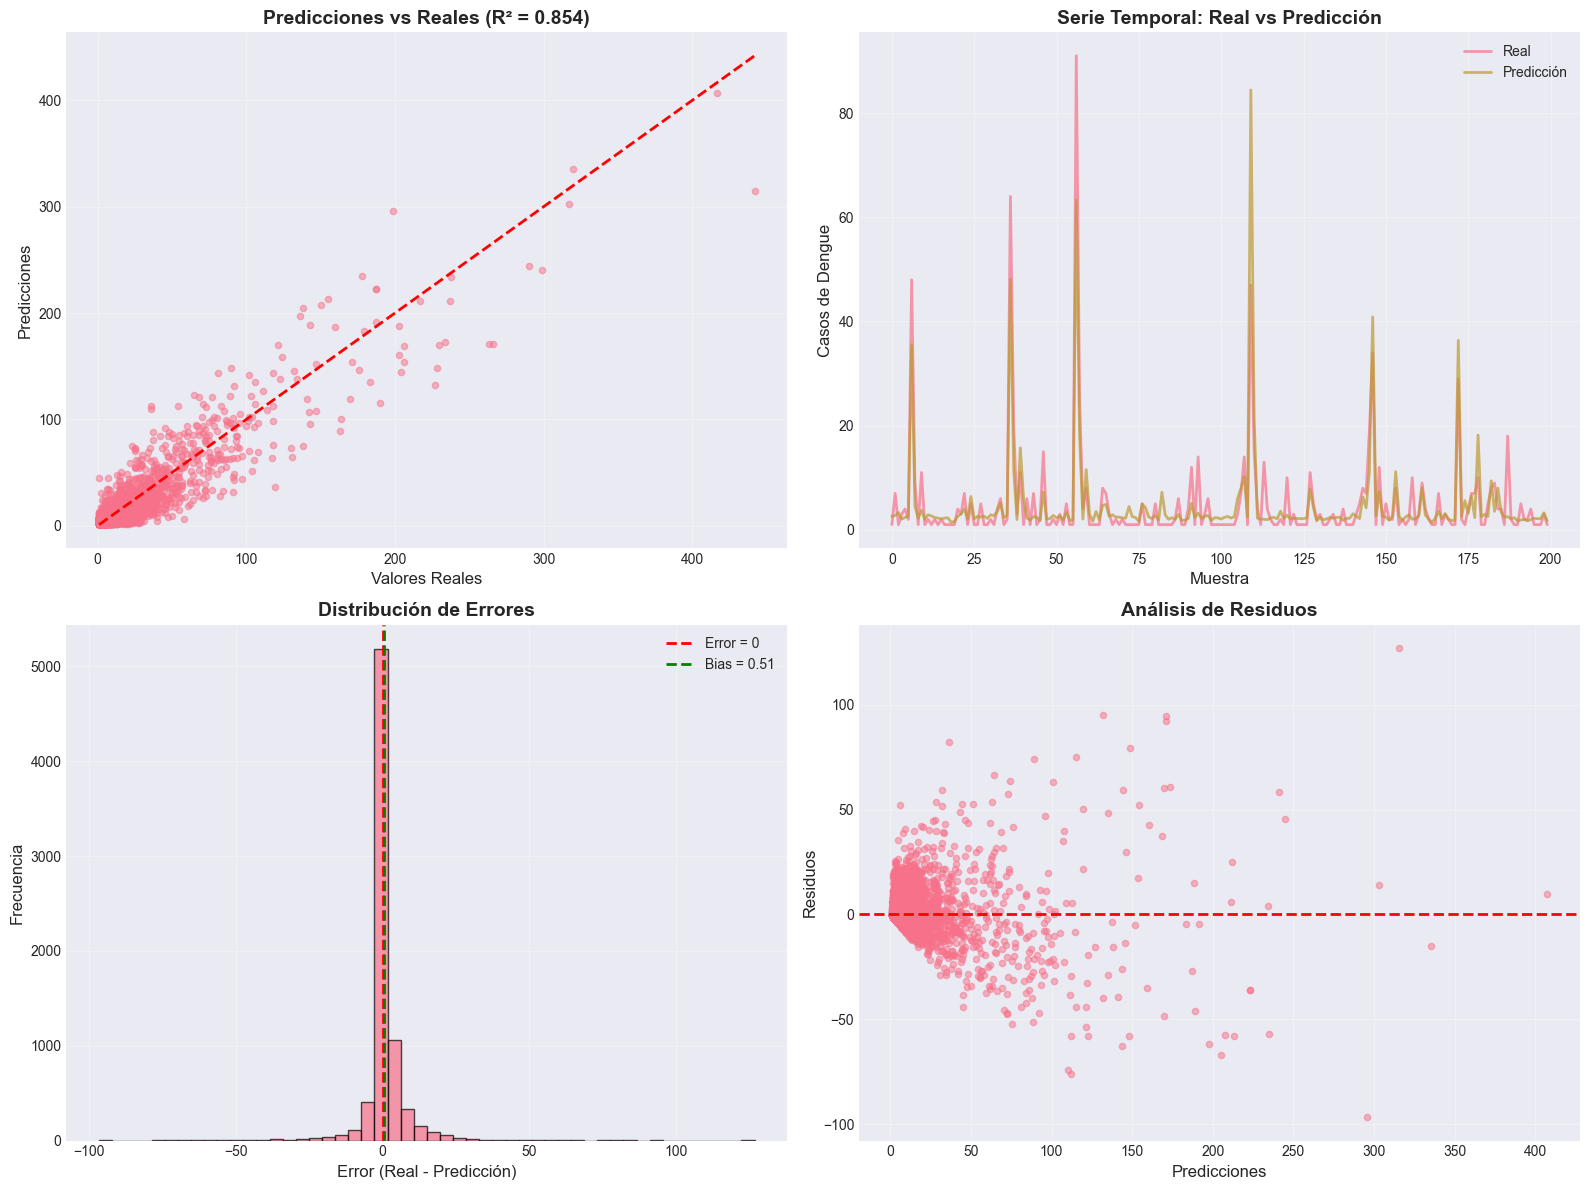

✅ Gráficos generados


In [119]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Predicciones vs Reales (Scatter)
axes[0, 0].scatter(y_val, y_pred, alpha=0.5, s=20)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reales', fontsize=12)
axes[0, 0].set_ylabel('Predicciones', fontsize=12)
axes[0, 0].set_title(f'Predicciones vs Reales (R² = {r2:.3f})', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Serie temporal
sample_size = min(200, len(y_val))
indices = np.arange(sample_size)
axes[0, 1].plot(indices, y_val[:sample_size], label='Real', linewidth=2, alpha=0.7)
axes[0, 1].plot(indices, y_pred[:sample_size], label='Predicción', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Muestra', fontsize=12)
axes[0, 1].set_ylabel('Casos de Dengue', fontsize=12)
axes[0, 1].set_title('Serie Temporal: Real vs Predicción', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Distribución de Errores
axes[1, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='r', linestyle='--', linewidth=2, label='Error = 0')
axes[1, 0].axvline(bias, color='g', linestyle='--', linewidth=2, label=f'Bias = {bias:.2f}')
axes[1, 0].set_xlabel('Error (Real - Predicción)', fontsize=12)
axes[1, 0].set_ylabel('Frecuencia', fontsize=12)
axes[1, 0].set_title('Distribución de Errores', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Residuos vs Predicciones
axes[1, 1].scatter(y_pred, errors, alpha=0.5, s=20)
axes[1, 1].axhline(0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicciones', fontsize=12)
axes[1, 1].set_ylabel('Residuos', fontsize=12)
axes[1, 1].set_title('Análisis de Residuos', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Gráficos generados")


### 7.2 Análisis por Rangos de Casos

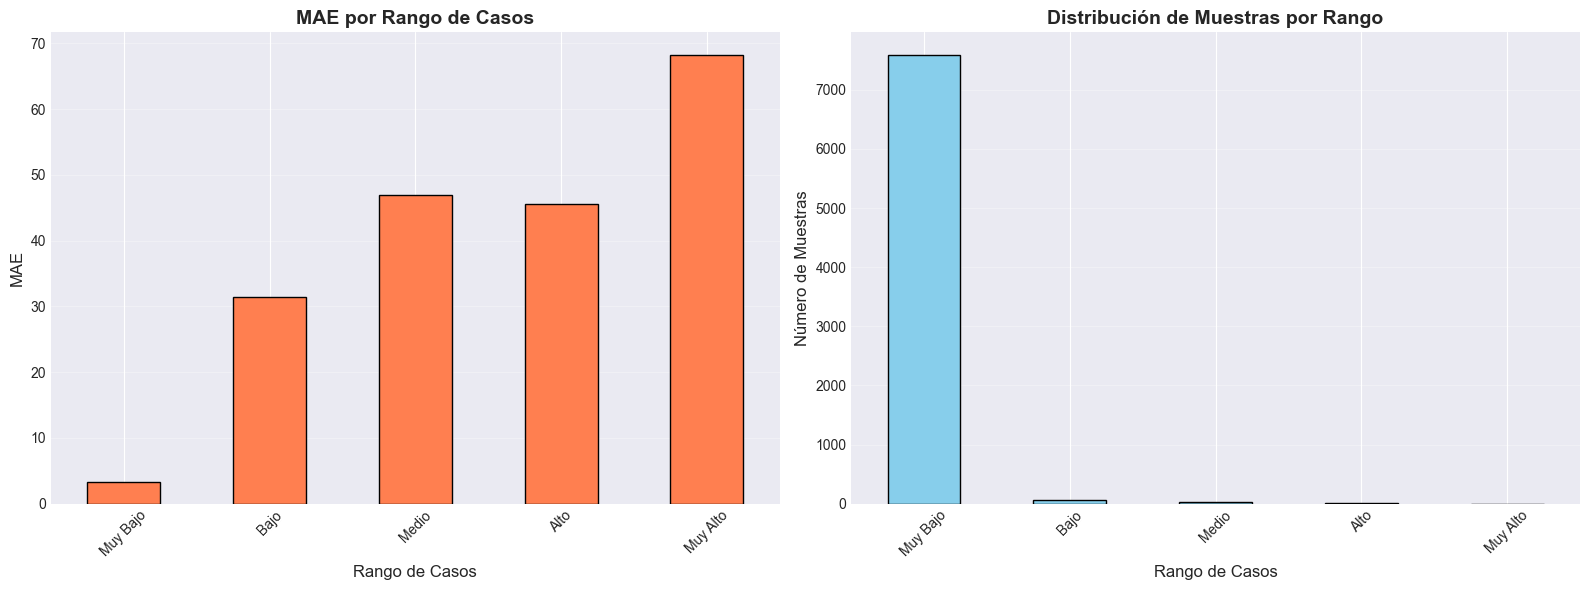

In [120]:

# Dividir en rangos de casos
df_analysis = pd.DataFrame({
    'real': y_val,
    'pred': y_pred,
    'error': errors
})

df_analysis['rango'] = pd.cut(y_val, bins=5, labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE por rango
mae_por_rango = df_analysis.groupby('rango')['error'].apply(lambda x: np.mean(np.abs(x)))
mae_por_rango.plot(kind='bar', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_title('MAE por Rango de Casos', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rango de Casos', fontsize=12)
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Distribución de casos por rango
df_analysis['rango'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Distribución de Muestras por Rango', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rango de Casos', fontsize=12)
axes[1].set_ylabel('Número de Muestras', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 9.3 Análisis de Features (Dengue Específico)

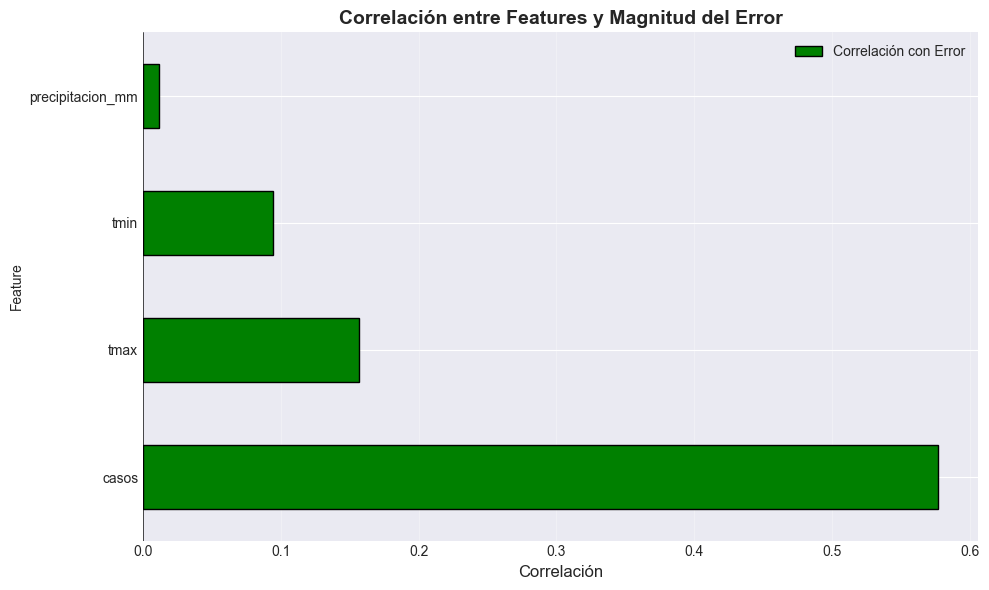

,Feature,Correlación con Error
0,casos,0.577286
3,tmax,0.156655
2,tmin,0.093996
1,precipitacion_mm,0.011230


In [121]:

# Análisis de correlación entre features y errores
feature_analysis = []
for i, feature in enumerate(FEATURES):
    feature_values = X_val[:, :, i].mean(axis=1)  # Promedio de la ventana
    corr = np.corrcoef(feature_values, np.abs(errors))[0, 1]
    feature_analysis.append({
        'Feature': feature,
        'Correlación con Error': corr
    })

feature_df = pd.DataFrame(feature_analysis).sort_values('Correlación con Error', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in feature_df['Correlación con Error']]
feature_df.plot(x='Feature', y='Correlación con Error', kind='barh', ax=ax, color=colors, edgecolor='black')
ax.set_title('Correlación entre Features y Magnitud del Error', fontsize=14, fontweight='bold')
ax.set_xlabel('Correlación', fontsize=12)
ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

feature_df


## 8. Análisis de Estacionalidad

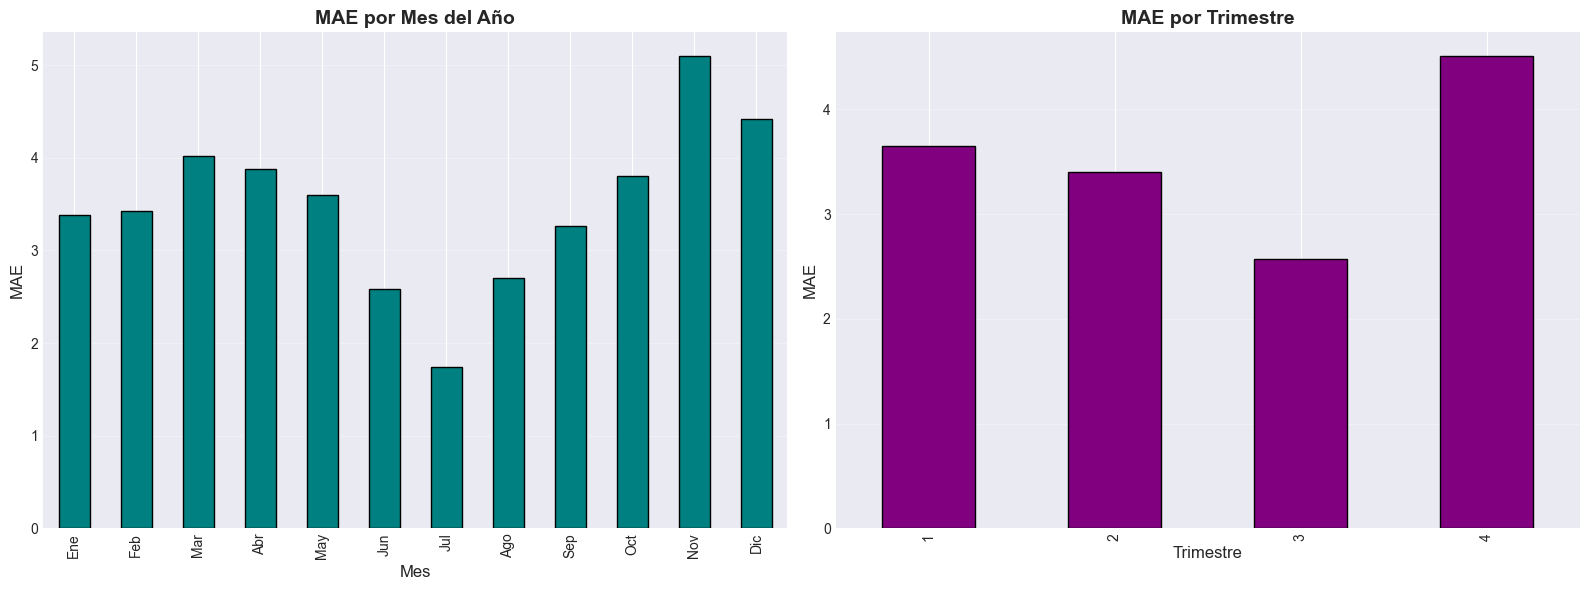

In [122]:

# Agregar información temporal usando las fechas de las secuencias
# Asegurar que dates_val tenga la misma longitud que df_analysis
if 'dates_val' in locals() and len(dates_val) == len(df_analysis):
    df_analysis['fecha'] = pd.to_datetime(dates_val)
elif 'dates_val' in locals():
    # Ajustar longitud si es necesario
    min_len = min(len(dates_val), len(df_analysis))
    df_analysis = df_analysis.iloc[:min_len].copy()
    df_analysis['fecha'] = pd.to_datetime(dates_val[:min_len])
else:
    # Si no hay dates_val, crear fechas sintéticas basadas en el índice
    print("⚠️ No se encontró dates_val, usando fechas sintéticas")
    start_date = pd.Timestamp('2020-01-01')
    df_analysis['fecha'] = pd.date_range(start=start_date, periods=len(df_analysis), freq='W')

df_analysis['mes'] = df_analysis['fecha'].dt.month
df_analysis['trimestre'] = df_analysis['mes'].apply(lambda x: (x-1)//3 + 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE por mes
mae_por_mes = df_analysis.groupby('mes')['error'].apply(lambda x: np.mean(np.abs(x)))
mae_por_mes.plot(kind='bar', ax=axes[0], color='teal', edgecolor='black')
axes[0].set_title('MAE por Mes del Año', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Mes', fontsize=12)
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
axes[0].grid(True, alpha=0.3, axis='y')

# MAE por trimestre
mae_por_trimestre = df_analysis.groupby('trimestre')['error'].apply(lambda x: np.mean(np.abs(x)))
mae_por_trimestre.plot(kind='bar', ax=axes[1], color='purple', edgecolor='black')
axes[1].set_title('MAE por Trimestre', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Trimestre', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 9. Resumen y Conclusiones

In [123]:

print("=" * 60)
print("RESUMEN DEL ANÁLISIS DEL MODELO DE DENGUE")
print("=" * 60)
print(f"\n📊 Métricas Principales:")
print(f"   • MAE:  {mae:.4f} casos")
print(f"   • RMSE: {rmse:.4f} casos")
print(f"   • R²:   {r2:.4f}")
print(f"   • MAPE: {mape*100:.2f}%")
print(f"\n📈 Interpretación:")
if r2 > 0.7:
    print("   ✅ Excelente capacidad predictiva (R² > 0.7)")
elif r2 > 0.5:
    print("   ✅ Buena capacidad predictiva (R² > 0.5)")
elif r2 > 0.3:
    print("   ⚠️ Capacidad predictiva moderada (R² > 0.3)")
else:
    print("   ⚠️ Capacidad predictiva limitada (R² < 0.3)")

if abs(bias) < mae * 0.1:
    print("   ✅ El modelo no tiene sesgo significativo")
else:
    print(f"   ⚠️ El modelo tiene un sesgo de {bias:.2f} casos")

print(f"\n🎯 Recomendaciones:")
if mape > 0.3:
    print("   • Considerar agregar más features (clima, movilidad, etc.)")
if abs(bias) > mae * 0.2:
    print("   • Revisar el preprocesamiento para reducir el sesgo")
if r2 < 0.5:
    print("   • Considerar ajustar hiperparámetros o arquitectura del modelo")

print("\n" + "=" * 60)


RESUMEN DEL ANÁLISIS DEL MODELO DE DENGUE

📊 Métricas Principales:
   • MAE:  3.6613 casos
   • RMSE: 8.1809 casos
   • R²:   0.8542
   • MAPE: 78.40%

📈 Interpretación:
   ✅ Excelente capacidad predictiva (R² > 0.7)
   ⚠️ El modelo tiene un sesgo de 0.51 casos

🎯 Recomendaciones:
   • Considerar agregar más features (clima, movilidad, etc.)

